In [33]:
%matplotlib inline
import pymysql
import os
import re
import copy
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from lxml import etree
import json
import time
import numpy as np

In [68]:
connection = pymysql.connect(host='127.0.0.1',
                             user='data',
                             password='data',
                             db='mag-new-160205',
                             charset='utf8mb4',
                             port=3306,
                             cursorclass=pymysql.cursors.DictCursor)
cursor = connection.cursor()

In [97]:
conference = 'SIGCOMM'
cursor.execute("SELECT ConferenceSeriesID FROM ConferenceSeries WHERE ShortName = '%s'" % conference)
conferenceID = cursor.fetchall()[0]['ConferenceSeriesID']
print (conferenceID)

44B13001


In [98]:
cursor.execute("SELECT PaperID FROM Papers WHERE ConferenceSeriesIDMappedToVenueName = '%s'" % conferenceID)
pid = []
for row in cursor.fetchall():
    pid.append(row['PaperID'])
print (len(pid))

4421


In [99]:
st_ref = time.time()
cursor.execute("SELECT PaperID, PaperReferenceID FROM PaperReferences WHERE \
    PaperID IN (SELECT PaperID FROM Papers WHERE ConferenceSeriesIDMappedToVenueName = '%s') \
    AND PaperReferenceID IN (SELECT PaperID FROM Papers WHERE ConferenceSeriesIDMappedToVenueName = '%s')" % (conferenceID, conferenceID))
ref_res = cursor.fetchall()
print ("Searching Time: %.3f" % (time.time() - st_ref))
print (len(ref_res))


Searching Time: 1275.869
7259


In [100]:
ref = []
for row in ref_res:
    ref.append((row['PaperID'], row['PaperReferenceID']))


In [101]:
def load_result(cursor, container, name):
    for row in cursor.fetchall():
        container.append(row[name])
    return container

In [102]:
auid_link_dict = {}
link_count = 1
st_build = time.time()
for refp, orip in ref:
    oriau = []
    refau = []
    oriyear = []
    refyear = []
    cursor.execute("SELECT AuthorID FROM PaperAuthorAffiliations WHERE PaperID = '%s' "% refp)
    load_result(cursor, refau, 'AuthorID')
    cursor.execute("SELECT PaperPublishYear FROM Papers WHERE PaperID = '%s'" % refp)
    load_result(cursor, refyear, 'PaperPublishYear')
        
    cursor.execute("SELECT AuthorID FROM PaperAuthorAffiliations WHERE PaperID = '%s' "% orip)
    load_result(cursor, oriau, 'AuthorID')
    cursor.execute("SELECT PaperPublishYear FROM Papers WHERE PaperID = '%s'" % orip)
    load_result(cursor, oriyear, 'PaperPublishYear')

    for au in oriau:
        if au not in auid_link_dict.keys():
            auid_link_dict[au] = {}
        for rau in refau:
            if rau not in auid_link_dict[au].keys():
                auid_link_dict[au][rau] = []
            auid_link_dict[au][rau].append((oriyear[0], refyear[0]))
            link_count += 1
print ("build time: %.3f" % (time.time() - st_build))
print ("link count: %d" % link_count)

build time: 17.215
link count: 113469


In [103]:
def export_link(link_dict, exdir):    
    if not os.path.exists(exdir):
        os.makedirs(exdir)
    filename = os.path.join(exdir, 'link.txt')
    f = open(filename, 'w')
    for au in link_dict.keys():
        for rau in link_dict[au].keys():
            f.write(au+'\t'+rau+'\t')
            ylen = len(link_dict[au][rau])
            for i in range(ylen-1):
                f.write(str(link_dict[au][rau][i][0])+' '+str(link_dict[au][rau][i][1])+'\t')
            f.write(str(link_dict[au][rau][ylen-1][0])+' '+str(str(link_dict[au][rau][ylen-1][1]))+'\t'+'\n')
    f.close()
    print ("export %s" % filename)

In [104]:
export_link(auid_link_dict, 'data/cite/%s' % conference)

export data/cite/SIGCOMM/link.txt


In [105]:
au_set = set()
for au in auid_link_dict.keys():
    au_set.add(au)
    for rau in auid_link_dict[au].keys():
        au_set.add(rau)
print ("author number: %d" % len(au_set))

author number: 4738


In [106]:
au_fos_all = [{}, {}, {}, {}]
au_fos_count = [[],[],[],[]]
for i in range(4):
    for au in au_set:
        cursor.execute("SELECT AuthorFOS.FieldOfStudyIDMappedToKeyword \
                                    FROM AuthorFOS, FieldsOfStudy WHERE \
                                    AuthorFOS.AuthorID = '%s' and FieldsOfStudy.FieldsOfStudyID = AuthorFOS.FieldOfStudyIDMappedToKeyword and \
                                    FieldsOfStudy.FieldsOfStudyLevel = 'L%d' " % (au, i))
        fos = []
        load_result(cursor, fos, 'FieldOfStudyIDMappedToKeyword')
        au_fos_all[i][au]  = fos
        au_fos_count[i].append(len(fos))

(array([ 2604.,   872.,   411.,   291.,   204.,   144.,   105.,    63.,
           36.,     8.]),
 array([  0. ,   1.9,   3.8,   5.7,   7.6,   9.5,  11.4,  13.3,  15.2,
         17.1,  19. ]),
 <a list of 10 Patch objects>)

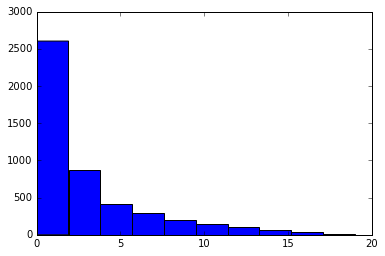

In [107]:
plt.hist(np.array(au_fos_count[0]), bins=10)

(array([  2.99800000e+03,   1.05700000e+03,   4.57000000e+02,
          1.27000000e+02,   5.80000000e+01,   2.50000000e+01,
          1.20000000e+01,   1.00000000e+00,   1.00000000e+00,
          2.00000000e+00]),
 array([   0. ,   19.6,   39.2,   58.8,   78.4,   98. ,  117.6,  137.2,
         156.8,  176.4,  196. ]),
 <a list of 10 Patch objects>)

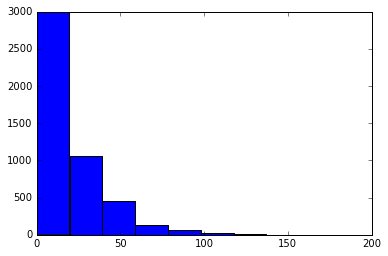

In [108]:
plt.hist(np.array(au_fos_count[1]), bins=10)

(array([  3.71300000e+03,   6.11000000e+02,   2.63000000e+02,
          8.90000000e+01,   3.60000000e+01,   2.00000000e+01,
          2.00000000e+00,   0.00000000e+00,   2.00000000e+00,
          2.00000000e+00]),
 array([   0. ,   48.3,   96.6,  144.9,  193.2,  241.5,  289.8,  338.1,
         386.4,  434.7,  483. ]),
 <a list of 10 Patch objects>)

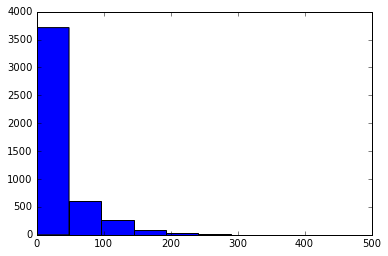

In [109]:
plt.hist(np.array(au_fos_count[2]), bins=10)

(array([  4.21300000e+03,   3.81000000e+02,   8.90000000e+01,
          3.40000000e+01,   1.50000000e+01,   2.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          2.00000000e+00]),
 array([    0. ,   702.3,  1404.6,  2106.9,  2809.2,  3511.5,  4213.8,
         4916.1,  5618.4,  6320.7,  7023. ]),
 <a list of 10 Patch objects>)

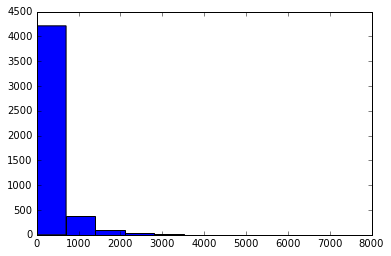

In [110]:
plt.hist(np.array(au_fos_count[3]), bins=10)

In [111]:
def export_fos(fos_dicts, exdir):
    if not os.path.exists(exdir):
        os.makedirs(exdir)
    for i in range(4):
        filename = os.path.join(exdir, 'fos_L%d.txt' % i)
        f = open(filename, 'w')
        count = 0
        for au in fos_dicts[i].keys():
            if len(fos_dicts[i][au]) == 0:
                f.write(au+'\n')
                continue
            f.write(au+'\t')
            for j in range(len(fos_dicts[i][au])-1):
                f.write(fos_dicts[i][au][j]+' ')
            f.write(fos_dicts[i][au][-1]+'\n')
            count += len(fos_dicts[i][au])
        f.close()
        print ("export %s: %d fos" % (filename, count))

In [112]:
export_fos(au_fos_all, 'data/cite/%s' % conference)

export data/cite/SIGCOMM/fos_L0.txt: 12885 fos
export data/cite/SIGCOMM/fos_L1.txt: 88702 fos
export data/cite/SIGCOMM/fos_L2.txt: 145456 fos
export data/cite/SIGCOMM/fos_L3.txt: 1276859 fos


In [113]:
fos_au_all = [{}, {}, {}, {}]
fos_au_count = [[], [], [], []]
for i in range(4):
    for au in au_fos_all[i].keys():
        for fos in au_fos_all[i][au]:
            if (fos not in fos_au_all[i].keys()):
                fos_au_all[i][fos] = set()
            fos_au_all[i][fos].add(au)
    for fos in fos_au_all[i].keys():
            setlen = len(fos_au_all[i][fos])
            fos_au_count[i].append(setlen)

(array([ 5.,  6.,  2.,  4.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([   26. ,   304.6,   583.2,   861.8,  1140.4,  1419. ,  1697.6,
         1976.2,  2254.8,  2533.4,  2812. ]),
 <a list of 10 Patch objects>)

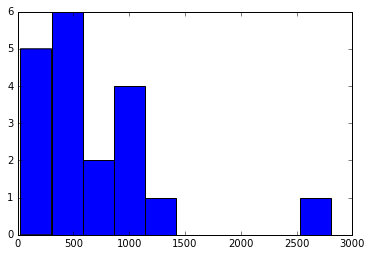

In [114]:
plt.hist(np.array(fos_au_count[0]), bins=10)

(array([ 211.,   20.,    9.,    7.,    4.,    7.,    5.,    0.,    1.,    1.]),
 array([  1.00000000e+00,   4.05200000e+02,   8.09400000e+02,
          1.21360000e+03,   1.61780000e+03,   2.02200000e+03,
          2.42620000e+03,   2.83040000e+03,   3.23460000e+03,
          3.63880000e+03,   4.04300000e+03]),
 <a list of 10 Patch objects>)

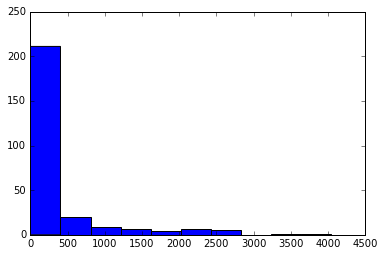

In [115]:
plt.hist(np.array(fos_au_count[1]), bins=10)

(array([ 913.,   63.,   26.,   21.,   16.,    7.,    6.,    2.,    2.,    4.]),
 array([  1.00000000e+00,   2.60700000e+02,   5.20400000e+02,
          7.80100000e+02,   1.03980000e+03,   1.29950000e+03,
          1.55920000e+03,   1.81890000e+03,   2.07860000e+03,
          2.33830000e+03,   2.59800000e+03]),
 <a list of 10 Patch objects>)

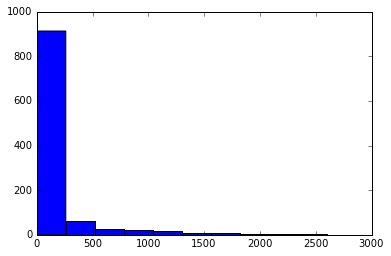

In [116]:
plt.hist(np.array(fos_au_count[2]), bins=10)

(array([  1.98580000e+04,   4.77000000e+02,   1.79000000e+02,
          8.10000000e+01,   5.20000000e+01,   1.70000000e+01,
          1.40000000e+01,   7.00000000e+00,   4.00000000e+00,
          1.00000000e+00]),
 array([  1.00000000e+00,   3.72300000e+02,   7.43600000e+02,
          1.11490000e+03,   1.48620000e+03,   1.85750000e+03,
          2.22880000e+03,   2.60010000e+03,   2.97140000e+03,
          3.34270000e+03,   3.71400000e+03]),
 <a list of 10 Patch objects>)

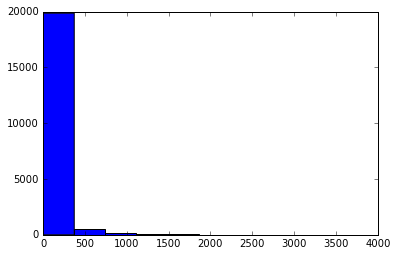

In [117]:
plt.hist(np.array(fos_au_count[3]), bins=10)

In [118]:
def com_export_fos(fos_au_dicts, exdir):
    if not os.path.exists(exdir):
        os.makedirs(exdir)
    for i in range(4):
        filename = os.path.join(exdir, 'c_fos_L%d.txt' % i)
        f = open(filename, 'w')
        for fos in fos_au_dicts[i].keys():
            setlen = len(fos_au_dicts[i][fos])
            if  setlen == 0:
                f.write(fos+'\n')
                continue
            f.write(fos+'\t')
            for j, au in enumerate(fos_au_dicts[i][fos]):
                f.write(au)
                if (j < setlen - 1):
                    f.write(' ')
            f.write('\n')
        f.close()
        print ("export %s" % filename)

In [119]:
com_export_fos(fos_au_all, 'data/site/%s' % conference)

export data/coau/SIGCOMM/c_fos_L0.txt
export data/coau/SIGCOMM/c_fos_L1.txt
export data/coau/SIGCOMM/c_fos_L2.txt
export data/coau/SIGCOMM/c_fos_L3.txt
